Exercise 1

Median error: 9.095717434400903 cm
Median error: 5.8375451263538025 cm
Median error: 5.074380165289256 cm
Median error: 3.8424362793776936 cm
Median error: 3.641679748822611 cm
Median error: 3.4329501915708818 cm


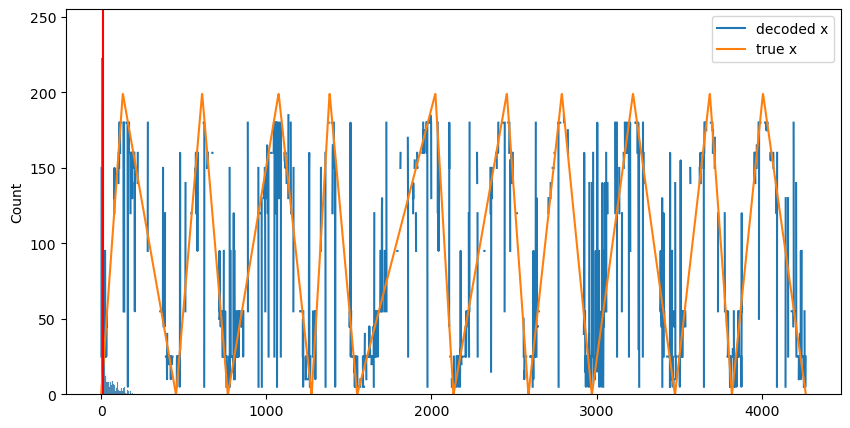

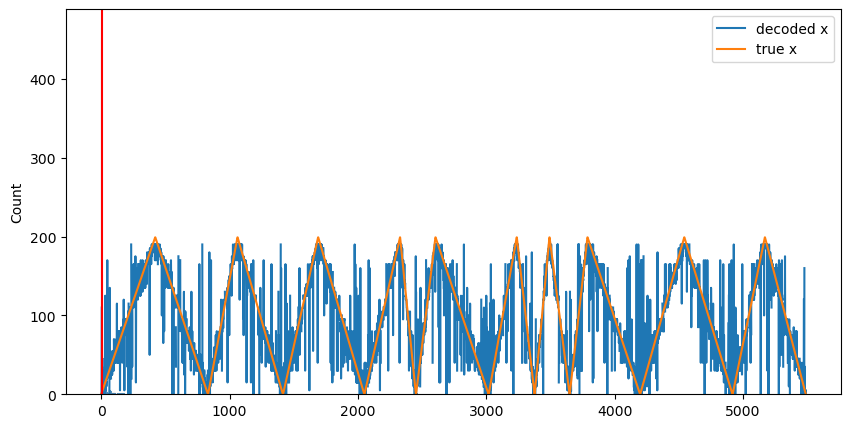

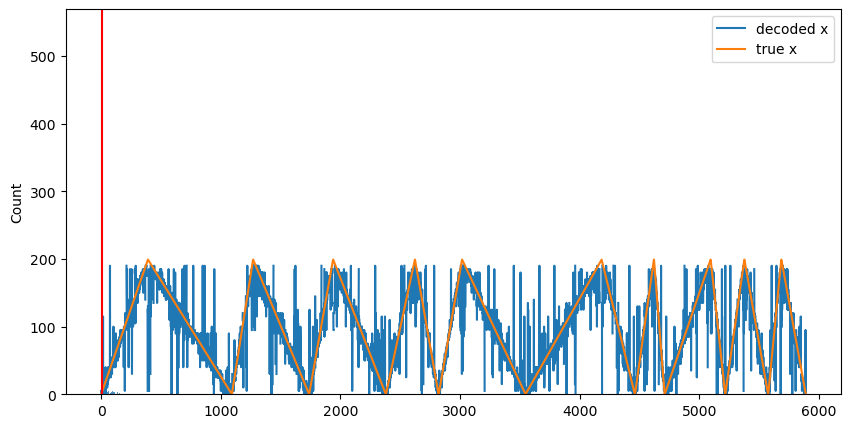

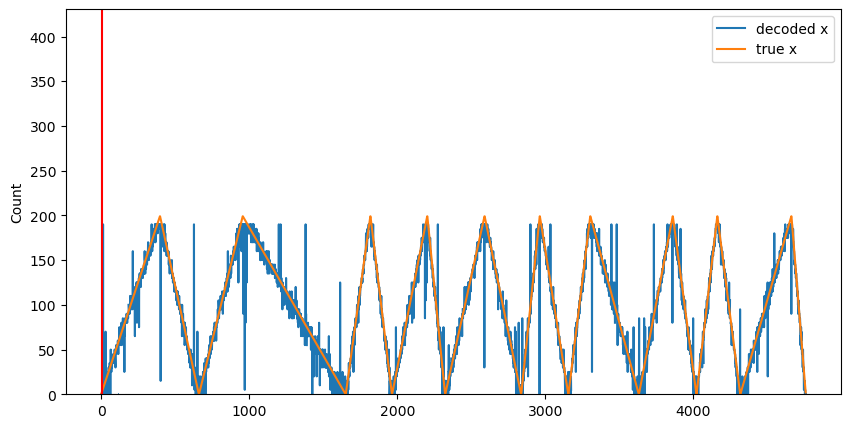

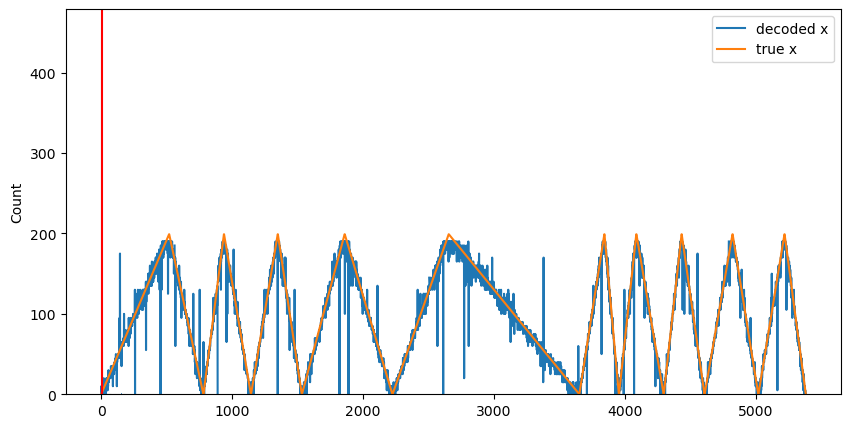

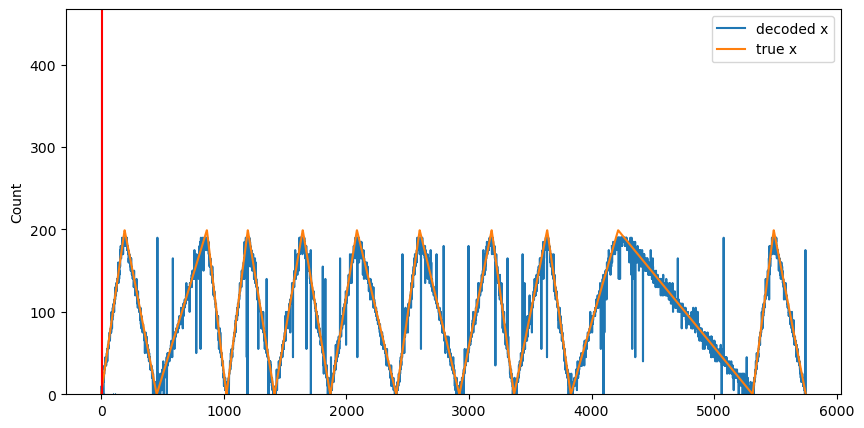

In [21]:
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
plt.rcParams['figure.figsize'] = [10, 5]
from ipywidgets import interact
import ipywidgets as widgets


track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_samples = [10, 30, 50, 70, 90, 100] # how many cells we are recording
for n_cells in n_samples:
    pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
    pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution
    pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

    bins = np.arange(0., 200.)
    true_firing_rate_maps = np.zeros((n_cells, len(bins)))
    for i in range(n_cells):
        true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

# GENERATE TRAJECTORY

    n_runs = 10
    use_stops = False
    av_running_speed = 10 # the average running speed (in cm/s)
    fps = 10 # the number of "video frames" per second 
    running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
    running_speed_b = np.random.chisquare(10, size=n_runs) 
    
    stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
    stopping_time_b = np.random.chisquare(15, size=n_runs)
    
    x = np.array([])
    
    
    for i in range(n_runs):
        stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
        run_length = len(bins) * fps / running_speed_a[i]
        run1 = np.linspace(0., float(len(bins)-1), int(run_length))
        stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
        run_length = len(bins) * fps / running_speed_b[i]
        run2 = np.linspace(len(bins)-1., 0., int(run_length))
        if use_stops:
            x = np.concatenate((x, stop1, run1, stop2, run2))
        else:
             x = np.concatenate((x, run1, run2))
        t = np.arange(len(x))/fps
    
        sampling_rate = 10000.
        t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
        x_sampling = np.floor(np.interp(t_sampling, t, x))
        noise_firing_rate = 0.1 # the baseline noise firing rate
        spikes = []
    
        for i in range(n_cells):
            inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
            spikes_loc = np.random.poisson(inst_rate/sampling_rate)
            sp = np.argwhere(spikes_loc)
            t_sp = t_sampling[sp]
            spikes.append(t_sp)

    spike_positions = [np.interp(s, t, x) for s in spikes]
    space_bins = np.arange(0., track_length, 5.) # binning in bins of 5 cms
    
    # we compute histograms for each cell
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.asarray(spikes_hist)
    
    # we also need an "occupancy histogram" in order to normalize the firing rates maps 
    occupancy = np.histogram(x, space_bins)[0] /  fps
    
    firing_rate_maps = spikes_hist / occupancy 
    
    spikes_count= [np.histogram(s,t)[0] for s in spikes]
    spikes_count = np.asarray(spikes_count).T # we transpose the matrix to have the more familiar (samples x features) shape
    
    # code decoding
    from scipy.stats import poisson
    
    true_x = x[:-1] # get rid of last timepoint to have same length as binned spikes
    decoding_times = t[:-1]
    
    x_decoded = np.zeros_like(true_x)
    
    for t_bin in range(len(decoding_times)):
        if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
            posterior = np.empty(firing_rate_maps.shape[-1])
    
            for i in range(len(posterior)):
                # Note that we work with log so that we can sum probabilities
                # instead of multiplying them 
                #posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
                posterior[i] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15))
            
            x_decoded[t_bin] = space_bins[np.argmax(posterior)]
        else:
            x_decoded[t_bin] = np.nan  

    plt.figure(figsize=(10,5))
    plt.plot(x_decoded,label= 'decoded x')
    plt.plot(true_x,label = 'true x')
    plt.legend()

    # error distribution
    mse = np.sqrt((true_x-x_decoded)**2)
    sns.histplot(mse)
    plt.axvline(x = np.nanmedian(mse),c='r')
    print(f'Median error: {np.nanmedian(mse)} cm')

In [8]:
import pickle

file_name = 'linear_track_data.pickle' # change this name when you save new data

out_data = {}
out_data['x'] = x
out_data['t'] = t
out_data['spikes'] = spikes
out_data['track_length'] = track_length
out_data['fps'] = fps

with open('data/'+file_name,'wb') as f:
    pickle.dump(out_data,f)

In [22]:
track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

In [23]:
bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

Median error: 50.89903846153848 cm
Median error: 50.89903846153848 cm
Median error: 50.89903846153848 cm
Median error: 50.89903846153848 cm


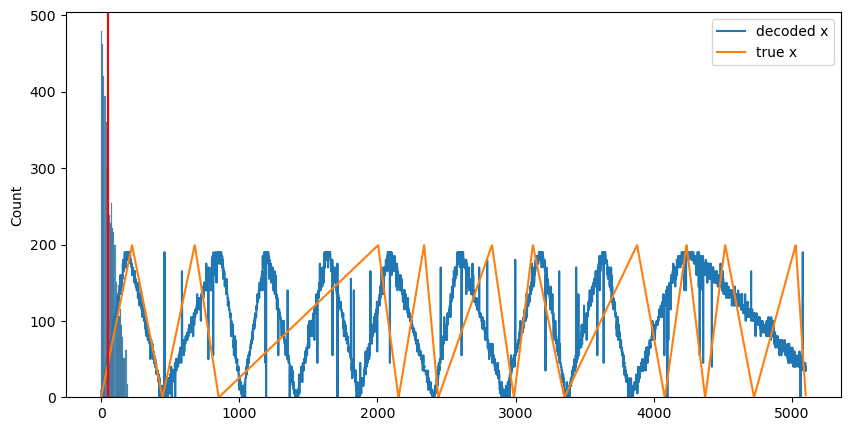

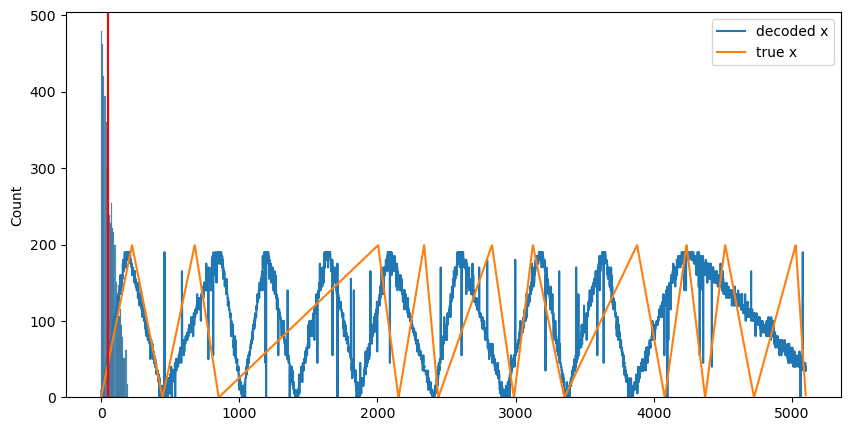

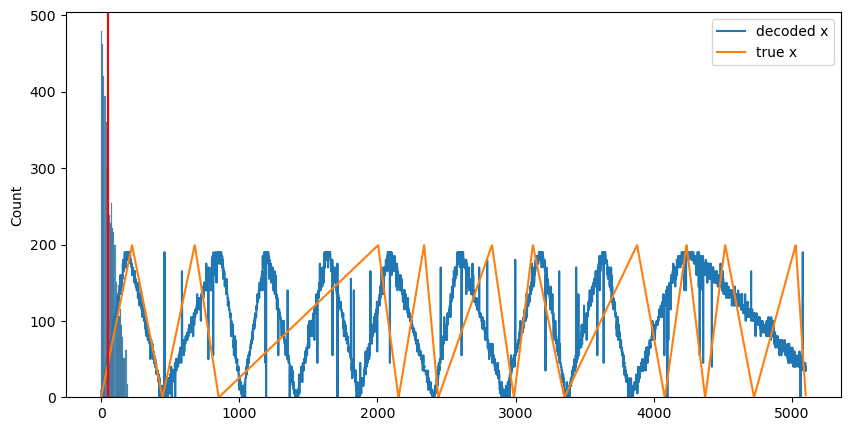

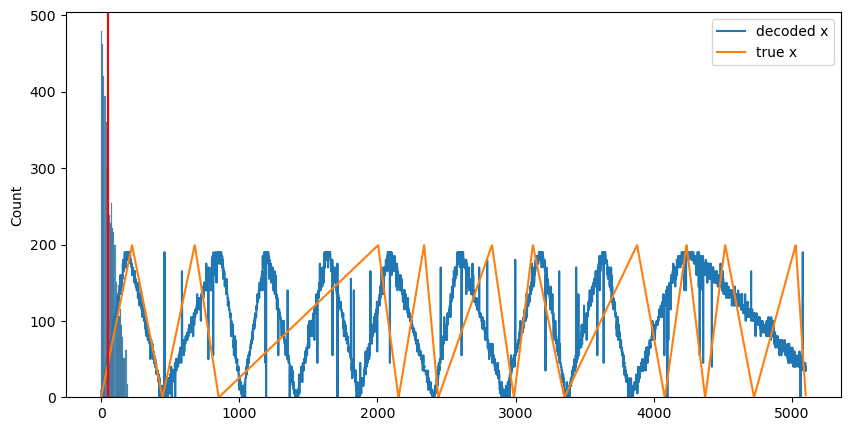

In [28]:
# GENERATE TRAJECTORY

n_runs = 10
use_stops = False
av_running_speed = 10 # the average running speed (in cm/s)
fps = 10 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])


for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    if use_stops:
        x = np.concatenate((x, stop1, run1, stop2, run2))
    else:
         x = np.concatenate((x, run1, run2))
t = np.arange(len(x))/fps

sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = [0.2, 0.4, 0.6, 0.8] # the baseline noise firing rate
spikes = []

for noise in noise_firing_rate:
    for i in range(n_cells):
        inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise
        spikes_loc = np.random.poisson(inst_rate/sampling_rate)
        sp = np.argwhere(spikes_loc)
        t_sp = t_sampling[sp]
        spikes.append(t_sp)

    true_x = x[:-1] # get rid of last timepoint to have same length as binned spikes
    decoding_times = t[:-1]
        
    x_decoded = np.zeros_like(true_x)
        
    for t_bin in range(len(decoding_times)):
        if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
            posterior = np.empty(firing_rate_maps.shape[-1])
        
            for i in range(len(posterior)):
                # Note that we work with log so that we can sum probabilities
                # instead of multiplying them 
                #posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
                posterior[i] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15))
                
            x_decoded[t_bin] = space_bins[np.argmax(posterior)]
        else:
            x_decoded[t_bin] = np.nan  
    
    plt.figure(figsize=(10,5))
    plt.plot(x_decoded,label= 'decoded x')
    plt.plot(true_x,label = 'true x')
    plt.legend()
    
    # error distribution
    mse = np.sqrt((true_x-x_decoded)**2)
    sns.histplot(mse)
    plt.axvline(x = np.nanmedian(mse),c='r')
    print(f'Median error: {np.nanmedian(mse)} cm')

The posterior distribution becomes wider when noise increases. This means that the decoding is less precise.

Exercise 2

Median error: 49.3512866029043 cm
Median error: 49.3512866029043 cm
Median error: 49.3512866029043 cm
Median error: 49.3512866029043 cm


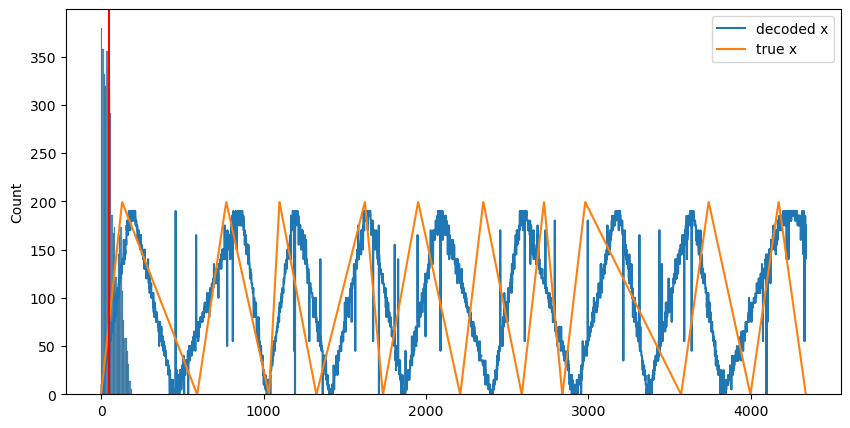

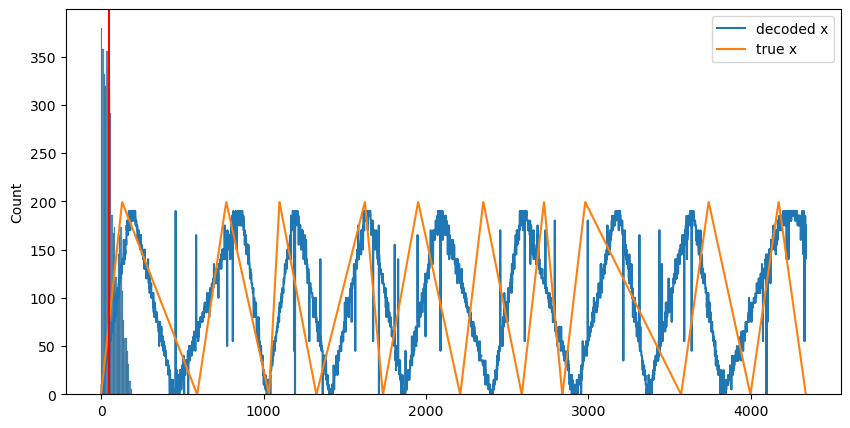

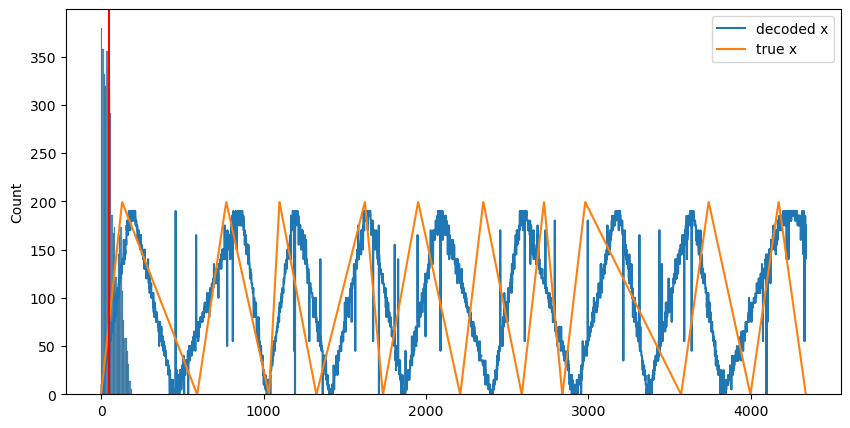

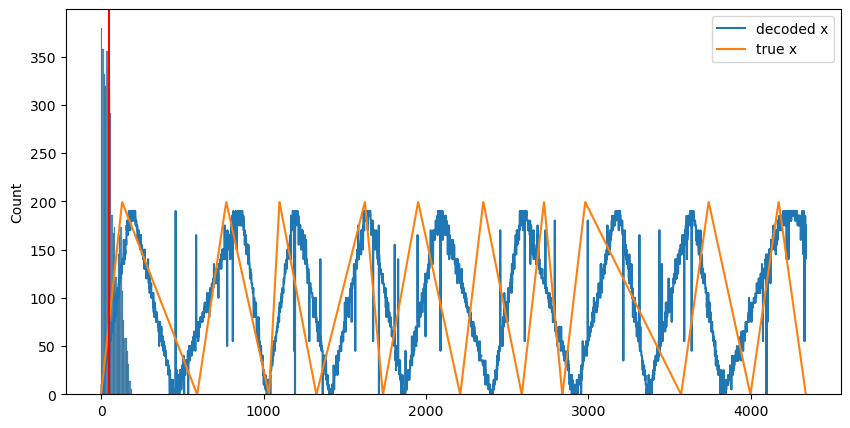

In [30]:
# GENERATE TRAJECTORY

n_runs = 10
use_stops = False
av_running_speed = 10 # the average running speed (in cm/s)
fps = 10 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])


for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    if use_stops:
        x = np.concatenate((x, stop1, run1, stop2, run2))
    else:
         x = np.concatenate((x, run1, run2))
t = np.arange(len(x))/fps

sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = [0.2, 0.4, 0.6, 0.8] # the baseline noise firing rate
spikes = []

for noise in noise_firing_rate:
    for i in range(n_cells):
        inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise
        spikes_loc = np.random.poisson(inst_rate/sampling_rate)
        sp = np.argwhere(spikes_loc)
        t_sp = t_sampling[sp]
        spikes.append(t_sp)

    true_x = x[:-1] # get rid of last timepoint to have same length as binned spikes
    decoding_times = t[:-1]
        
    x_decoded = np.zeros_like(true_x)
        
    for t_bin in range(len(decoding_times)):
        if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
            posterior = np.empty(firing_rate_maps.shape[-1])
        
            for i in range(len(posterior)):
                # Note that we work with log so that we can sum probabilities
                # instead of multiplying them 
                #posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
                posterior[i] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15))
            x_decoded[t_bin] = space_bins[np.argmax(posterior)]
        else:
            x_decoded[t_bin] = np.nan  
    
    plt.figure(figsize=(10,5))
    plt.plot(x_decoded,label= 'decoded x')
    plt.plot(true_x,label = 'true x')
    plt.legend()
    
    # error distribution
    mse = np.sqrt((true_x-x_decoded)**2)
    sns.histplot(mse)
    plt.axvline(x = np.nanmedian(mse),c='r')
    print(f'Median error: {np.nanmedian(mse)} cm')

Exercise 3

With the substituted code, taking the logarithm of the sum of probabilities instead of computing the logarithm of the Poisson probability mass function directly, results in a loss of precision. 